In [23]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sharedcontrolpaper.force_sensitive_stopping_task_utils import calculate_confidence_interval_for_intervals, collect_trial_metric, SECONDS_TO_MILLISECONDS

In [24]:
%store -r shared_control_metrics
%store -r final_aggregated_results
%store -r non_ai_proportion_ones
%store -r ai_failed_proportion_ones
%store -r ai_assisted_proportion_ones
%store -r survey_scores
%store -r survey_results

In [25]:
parent_directory = os.path.dirname(os.getcwd())

## Supplemental Figure 1

Mapping of Question Numbers to Original Questions:
Q1: AI is making our daily lives easier.
Q2: I believe that increased use of artificial intelligence will make the world a safer place.
Q3: I trust a self driving car to drive safer than I would normally.
Q4: I trust artificial intelligence.
Q5: I trust companies that do not use AI over companies that do.
Q6: I would prefer to drive a self-driving car over a regular car.
Q7: More vehicles, software, and appliances should make use of AI.


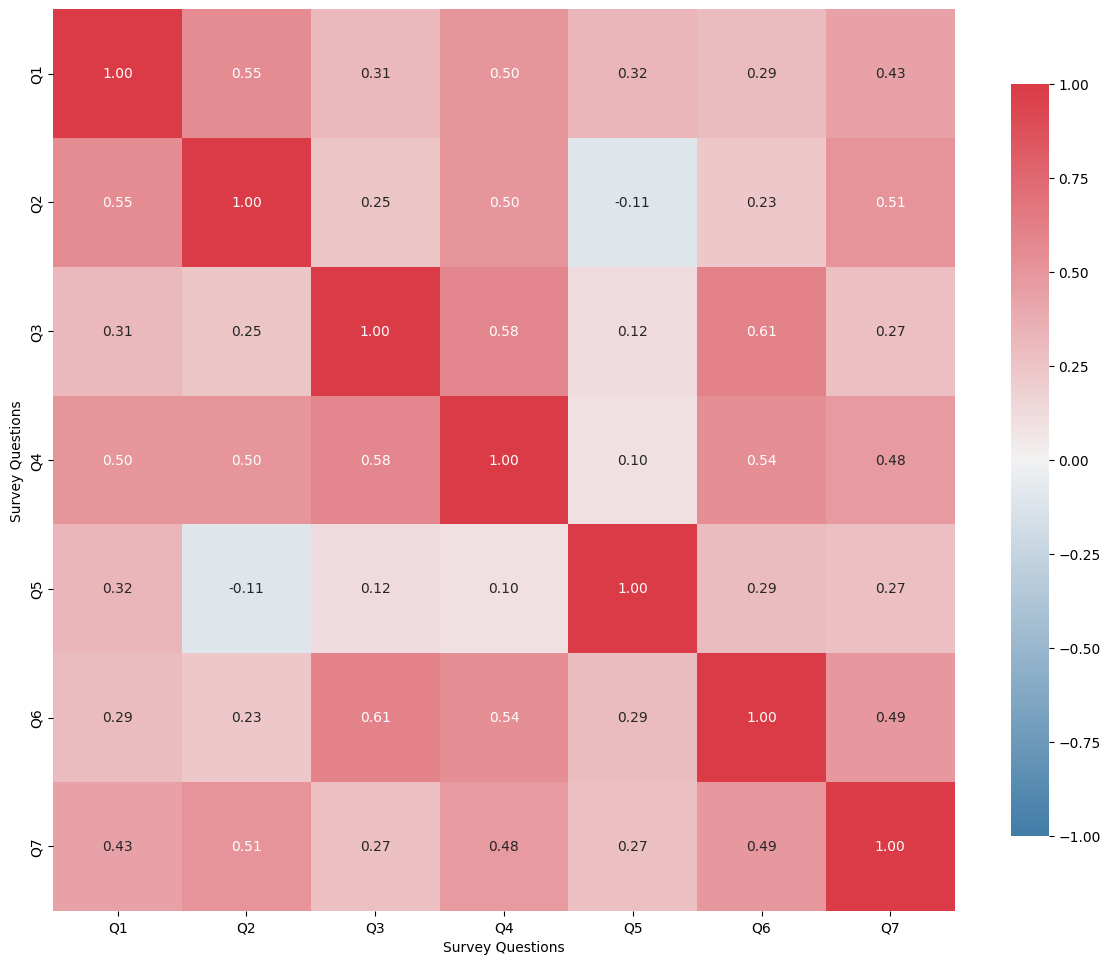

In [26]:
# Step 1: Extract corrected values into a DataFrame
combined_data = []

for subject_id, details in survey_results.items():
    df = details['data']
    for idx, row in df.iterrows():
        combined_data.append({'subject_id': subject_id, 'text': row['text'], 'corrected_value': row['corrected_value']})

# Step 2: Create a pivot DataFrame
pivot_df = pd.DataFrame(combined_data)
pivot_df = pivot_df.pivot(index='subject_id', columns='text', values='corrected_value')

# Step 3: Create a mapping from question number to original questions
question_mapping = {f'Q{i + 1}': question for i, question in enumerate(pivot_df.columns)}

print("Mapping of Question Numbers to Original Questions:")
for q_num, original_question in question_mapping.items():
    print(f"{q_num}: {original_question}")

# Step 4: Rename the columns to Q1, Q2, ..., Q7
new_columns = [f'Q{i + 1}' for i in range(len(pivot_df.columns))]
pivot_df.columns = new_columns

# Step 5: Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Step 6: Create a heatmap of the correlation matrix
cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, square=True, 
            cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10}) 

plt.xlabel("Survey Questions")
plt.ylabel("Survey Questions")

tick_positions = np.arange(len(new_columns)) + 0.5
plt.xticks(ticks=tick_positions, labels=new_columns)
plt.yticks(ticks=tick_positions, labels=new_columns)

plt.tight_layout()

plt.savefig(f'{parent_directory}/figures/figureS1.png', dpi=300) 
plt.show()

## Supplemental Figure 2

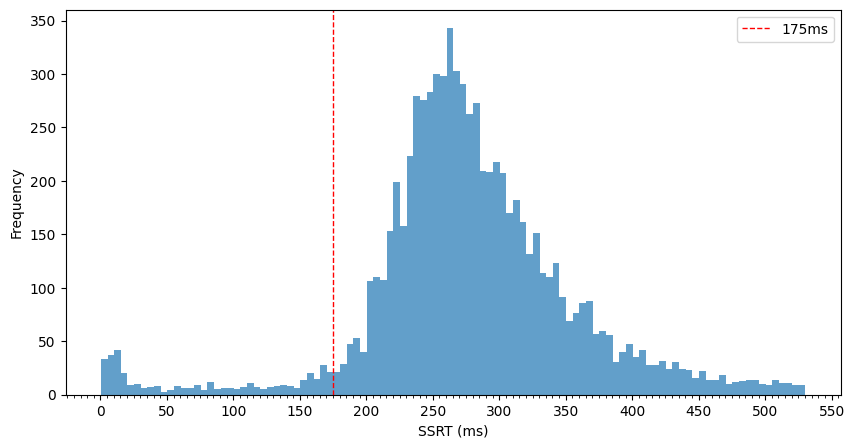

In [27]:
all_ssrt_data = []
for subject, subject_data in shared_control_metrics.items():
    results = collect_trial_metric(subject, subject_data, 'ssrt_without_minimum_ssrt', aggregate_ai=False)
    df = pd.DataFrame({
        'subject': subject,
        'ssrt': results['non_ai'] + results['ai_failed'] + results['ai_assisted']
    })
    all_ssrt_data.append(df)

ssrt_series = pd.concat(all_ssrt_data, ignore_index=True)['ssrt']
ssrt_series_ms = ssrt_series * 1000  # Convert to milliseconds

#Filter values
below_06_ms = ssrt_series_ms[ssrt_series_ms <= 600] #Filter values below 0.6s = 600ms

plt.figure(figsize=(10, 5))
plt.hist(below_06_ms, bins=np.arange(below_06_ms.min(), 530 + 5, 5), alpha=0.7)
plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')

plt.xlabel('SSRT (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.gca().xaxis.set_minor_locator(MultipleLocator(5))

plt.savefig(f'{parent_directory}/figures/figureS2.png')
plt.show()

## Supplemental Figure 3: Proportion of full pressure (pressure = 1)  timepoints at each time interval until stop onset.

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_98003/689424296.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x=time_intervals, y=non_ai_proportion_ones.loc['mean across all subjects'],
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_98003/689424296.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x=time_intervals, y=ai_failed_proportion_ones.loc['mean across all subjects'],
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_98003/689424296.py:44: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x=time_intervals, y=ai_assisted_proportion_ones.loc['mean across all subjects

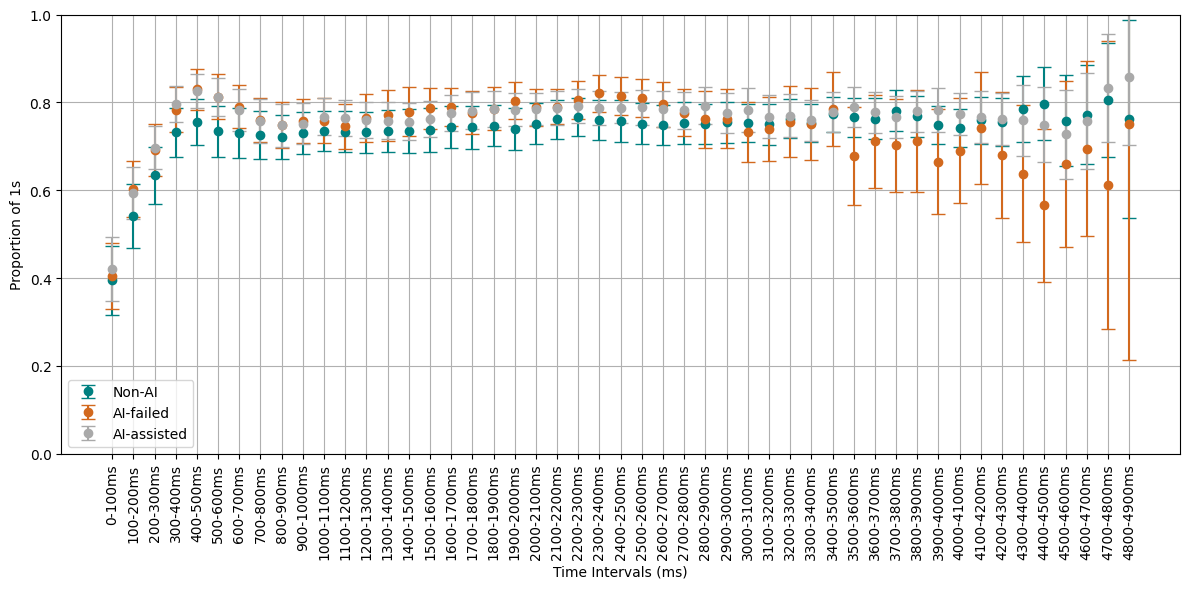

In [28]:
# Calculate confidence intervals for each condition and time interval
time_intervals = non_ai_proportion_ones.columns

non_ai_cis = []
for col in time_intervals:
    lower, upper = calculate_confidence_interval_for_intervals(non_ai_proportion_ones[col])
    non_ai_cis.append((lower, upper))


ai_failed_cis = []
for col in time_intervals:
    lower, upper = calculate_confidence_interval_for_intervals(ai_failed_proportion_ones[col])
    ai_failed_cis.append((lower, upper))


ai_assisted_cis = []
for col in time_intervals:
    lower, upper = calculate_confidence_interval_for_intervals(ai_assisted_proportion_ones[col])
    ai_assisted_cis.append((lower, upper))

#Create arrays of lower and upper bounds of the CI
non_ai_lower = np.array([ci[0] for ci in non_ai_cis])
non_ai_upper = np.array([ci[1] for ci in non_ai_cis])

ai_failed_lower = np.array([ci[0] for ci in ai_failed_cis])
ai_failed_upper = np.array([ci[1] for ci in ai_failed_cis])

ai_assisted_lower = np.array([ci[0] for ci in ai_assisted_cis])
ai_assisted_upper = np.array([ci[1] for ci in ai_assisted_cis])

# Create the plot with confidence intervals
plt.figure(figsize=(12, 6))

plt.errorbar(x=time_intervals, y=non_ai_proportion_ones.loc['mean across all subjects'], 
             yerr=[non_ai_proportion_ones.loc['mean across all subjects'] - non_ai_lower, non_ai_upper - non_ai_proportion_ones.loc['mean across all subjects']],
             label='Non-AI', color='teal', marker='o', capsize=5, fmt='o')


plt.errorbar(x=time_intervals, y=ai_failed_proportion_ones.loc['mean across all subjects'], 
             yerr=[ai_failed_proportion_ones.loc['mean across all subjects'] - ai_failed_lower, ai_failed_upper - ai_failed_proportion_ones.loc['mean across all subjects']],
             label='AI-failed', color='chocolate', marker='o', capsize=5, fmt='o')


plt.errorbar(x=time_intervals, y=ai_assisted_proportion_ones.loc['mean across all subjects'], 
             yerr=[ai_assisted_proportion_ones.loc['mean across all subjects'] - ai_assisted_lower, ai_assisted_upper - ai_assisted_proportion_ones.loc['mean across all subjects']],
             label='AI-assisted', color='darkgray', marker='o', capsize=5, fmt='o')

plt.xlabel('Time Intervals (ms)')
plt.ylabel("Proportion of 1s")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figureS3.png', dpi=300)
plt.show()

## Supplemental Figure 4

In [29]:
# List of survey question column names
question_list = [
    "AI is making our daily lives easier.",
    "I believe that increased use of artificial intelligence will make the world a safer place.",
    'I trust a self driving car to drive safer than I would normally.',
    "I trust artificial intelligence.",
    "I trust companies that do not use AI over companies that do.",
    "I would prefer to drive a self-driving car over a regular car.",
    "More vehicles, software, and appliances should make use of AI."
]

def frequency_of_responses_to_survey(questions, survey_results):
    """
    Generate a grid of bar charts of responses for a list of survey questions.
    
    Parameters:
    - questions: A list of survey question texts.
    - survey_results: A dictionary containing survey responses with subject ID mapping.
    """
    num_questions = len(questions)
    cols = 3  # Number of columns for the grid
    rows = (num_questions + cols - 1) // cols  # Calculate number of rows needed for the grid

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, column_name in enumerate(questions):
        # Handle reverse coding for the specific question
        if column_name == "I trust companies that do not use AI over companies that do.":
            survey_results[column_name] = 6 - survey_results[column_name]

        # Count responses
        response_counts = np.bincount(survey_results[column_name].dropna().astype(int), minlength=6)[1:]  # Count of responses excluding 0

        # Plot frequency of responses in the corresponding subplot
        axes[i].bar(np.arange(1, 6), response_counts, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_xticks(np.arange(1, 6))
        axes[i].set_xlabel("Survey Response")
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f'Q{i + 1}')
        axes[i].grid(axis='y')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{parent_directory}/figures/figureS4.png', dpi=300) 
    plt.show()

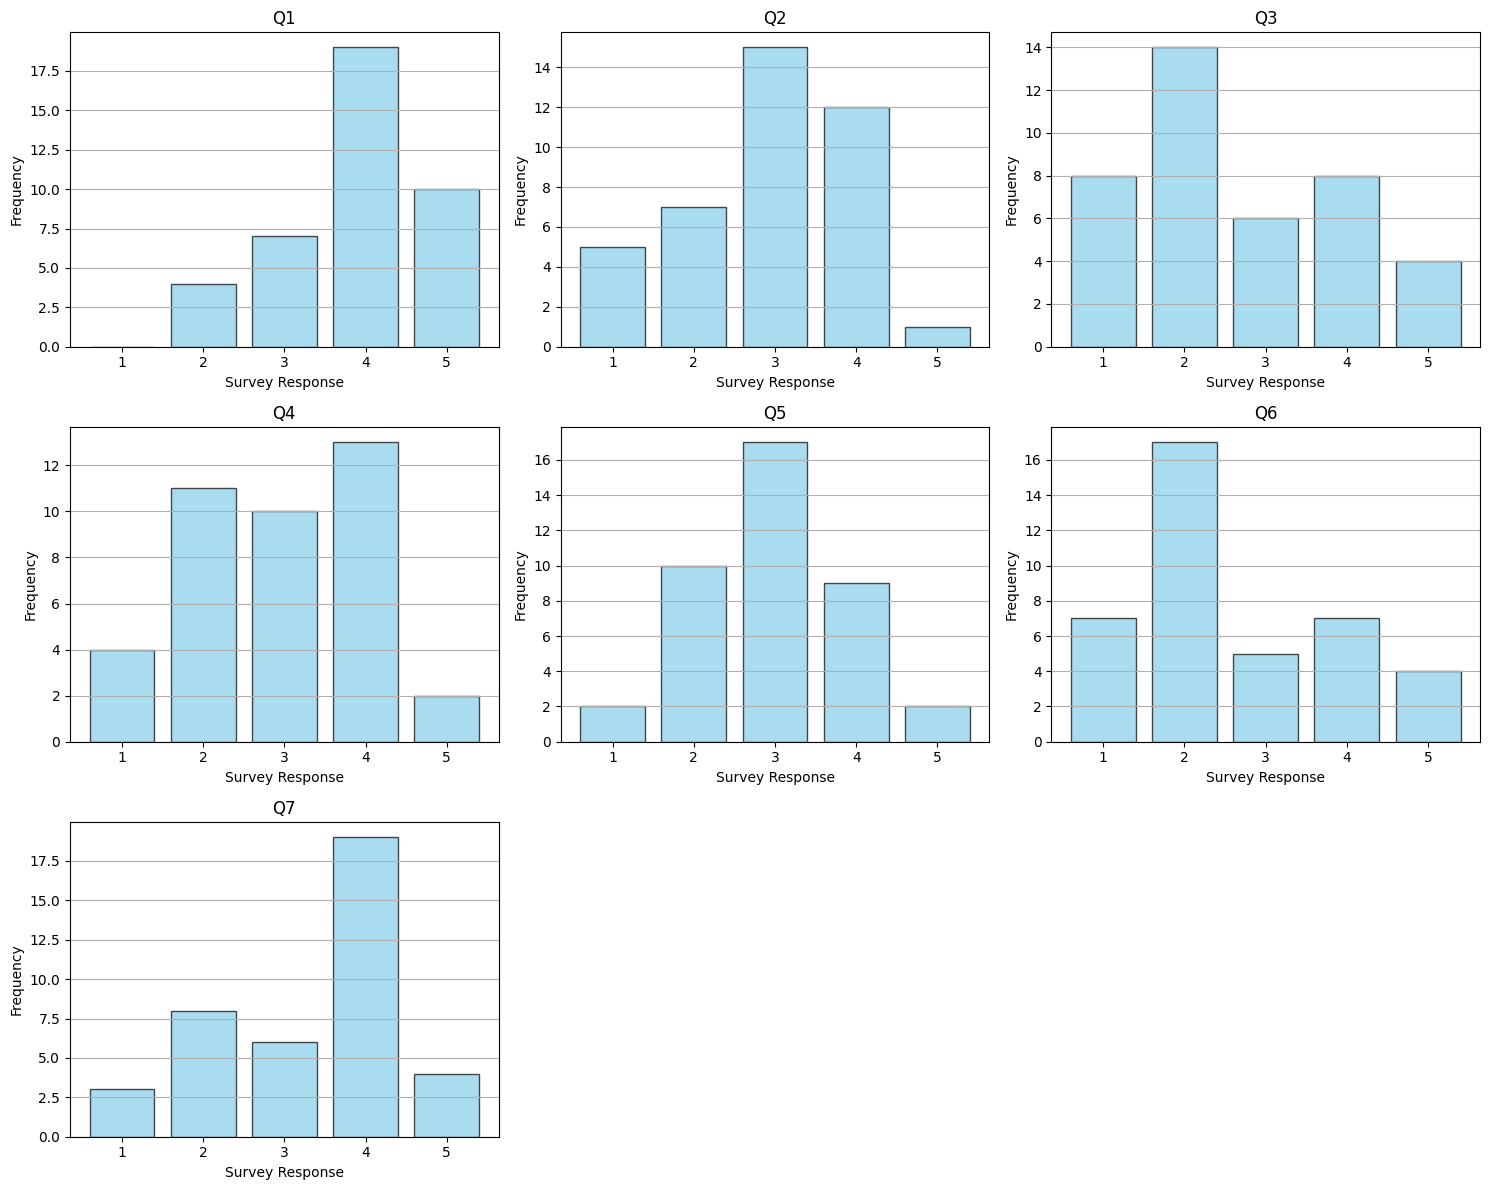

In [30]:
frequency_of_responses_to_survey(question_list, survey_scores)

## Supplemental Figure 5

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_98003/2861449365.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


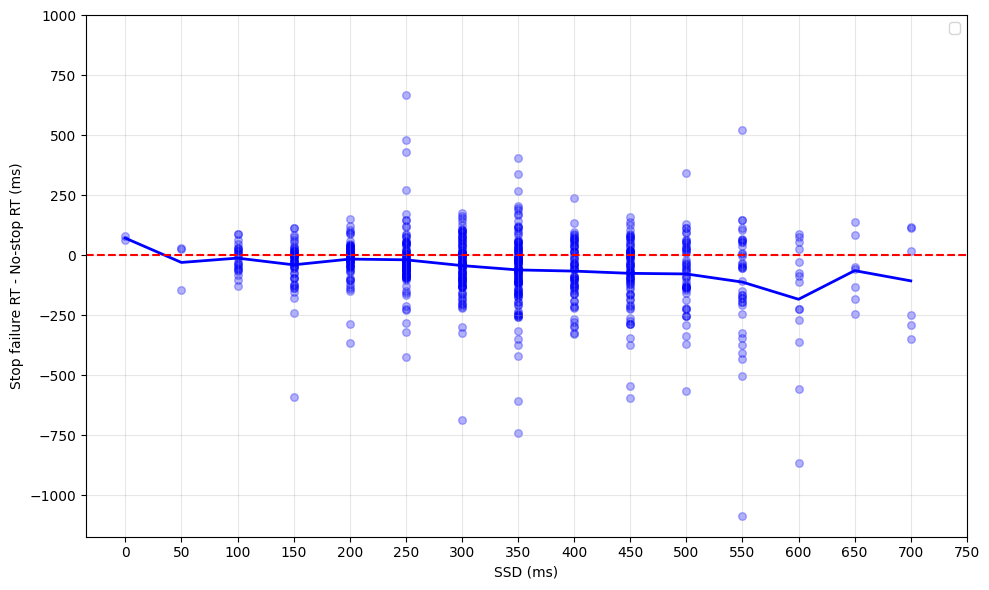

In [31]:
# Assuming final_aggregated_results is your DataFrame
ssd_values = final_aggregated_results['ssd'].values
all_differences = final_aggregated_results['all_differences']

# Flatten all_differences and corresponding ssd values
# We need to create a new list for x and y values
flattened_ssd_values = []
flattened_diff_values = []

for ssd, diffs in zip(ssd_values, all_differences):
    # Expand the list of differences into a flat structure
    for diff in diffs:
        flattened_ssd_values.append(ssd)
        flattened_diff_values.append(diff)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all individual data points
plt.scatter(flattened_ssd_values, flattened_diff_values, color='blue', alpha=0.3, s=30)

# Calculate and plot the mean differences per SSD
mean_data = (
    pd.DataFrame({'SSD': flattened_ssd_values, 'Difference': flattened_diff_values})
    .groupby('SSD')['Difference']
    .mean()
)

plt.plot(mean_data.index, mean_data.values, color='blue', linewidth=2)

# Customize the plot
plt.axhline(0, color='red', linestyle='--')
plt.xticks(np.arange(0, 800, 50))
plt.xlabel('SSD (ms)')
plt.yticks(np.arange(-1000, 1250, 250))
plt.ylabel('Stop failure RT - No-stop RT (ms)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot to a file
plt.savefig(f'{parent_directory}/figures/figureS5.png')
plt.show()